<a href="https://colab.research.google.com/github/ghkdwnwsdud/ksebProject/blob/main/ImgCaptModel_initialAttempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install TensorFlow
%pip install Keras
%pip install pillow
%pip install NumPy
%pip install tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
#from keras.layers.merge import add
from keras.layers import Add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

<ipython-input-3-6318fea0bae3>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [ ]:
import zipfile
import shutil

zip_path = '/content/drive/MyDrive/data/Flickr8k_Dataset.zip'
data_dir = '/content/Flickr8k_Dataset'

# 압축 해제
if not os.path.exists(data_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)

print("Dataset unzipped successfully")

drivetxt_path = '/content/drive/MyDrive/data/Flickr8k_text'
local_path = '/content/Flickr8k_text'

# 데이터셋을 로컬 디스크로 복사
if not os.path.exists(local_path):
    shutil.copytree(drivetxt_path, local_path)

Dataset unzipped successfully


In [ ]:
# Load the document file into memory
def load_fp(filename):
    # Open file to read
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Get all images with their captions
def img_capt(filename):
    file = load_fp(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions:
        if caption.strip() == '':
            continue
        img, caption = caption.split('\t')
        img = img[:-2]  # remove the last 2 characters from image name
        if img not in descriptions:
            descriptions[img] = [caption]
        else:
            descriptions[img].append(caption)
    return descriptions

# Data cleaning function will convert all upper case alphabets to lowercase, remove punctuations, and words containing numbers
def txt_clean(captions):
    table = str.maketrans('', '', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):
            img_caption = img_caption.replace("-", " ")
            descp = img_caption.split()
            # Uppercase to lowercase
            descp = [wrd.lower() for wrd in descp]
            # Remove punctuation from each token
            descp = [wrd.translate(table) for wrd in descp]
            # Remove hanging 's and 'a'
            descp = [wrd for wrd in descp if len(wrd) > 1]
            # Remove words containing numbers with them
            descp = [wrd for wrd in descp if wrd.isalpha()]
            # Converting back to string
            img_caption = ' '.join(descp)
            captions[img][i] = img_caption
    return captions

# To build vocab of all unique words
def txt_vocab(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

# To save all descriptions in one file
def save_descriptions(descriptions, filename):
    lines = []
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    with open(filename, "w") as file:
        file.write(data)

### paths need to be fixed

# Set these paths according to your project folder in your system
dataset_text = "/content/Flickr8k_text"
dataset_images = "/content/Flickr8k_Dataset/Flicker8k_Dataset"

# To prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"

# Loading the file that contains all data and map them into descriptions dictionary
descriptions = img_capt(filename)
print("Length of descriptions =", len(descriptions))

# Cleaning the descriptions
clean_descriptions = txt_clean(descriptions)

# To build vocabulary
vocabulary = txt_vocab(clean_descriptions)
print("Length of vocabulary =", len(vocabulary))

# Saving all descriptions in one file
save_descriptions(clean_descriptions, "descriptions.txt")


Length of descriptions = 8092
Length of vocabulary = 8422


In [ ]:
# Xception model to extract features
model = Xception( include_top=False, pooling='avg' )

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
def extract_features(directory):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for pic in tqdm(os.listdir(directory)):
        file = os.path.join(directory, pic)
        image = Image.open(file)
        image = image.resize((299, 299))

        image = img_to_array(image)   ### added by gpt

        image = np.expand_dims(image, axis=0)
        # Preprocess input as per the Xception model requirements
        image = image / 127.5
        image = image - 1.0
        feature = model.predict(image)
        features[pic] = feature
    return features

# Directory where images are stored
#dataset_images = "D:/shikha/Project - Image Caption Generator/Flicker8k_Dataset"

# 2048 feature vectors

# Extract features from all images in the dataset
features = extract_features(dataset_images)

# Save the features into a pickle file
with open("features.p", "wb") as file:
    dump(features, file)

# Load the features directly from the pickle file
with open("features.p", "rb") as file:
    features = load(file)

<ipython-input-7-0eb553cc6433>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pic in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 24ms/step


In [ ]:
# Load the list of photos from the given filename
def load_photos(filename):
    file = load_fp(filename)
    photos = file.split("\n")[:-1]
    return photos

# Load clean descriptions for a given list of photos
def load_clean_descriptions(filename, photos):
    file = load_fp(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words) < 1:
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            #desc = ' ' + " ".join(image_caption) + ' '
            desc = 'startseq ' + " ".join(image_caption) + ' endseq'    ### fixed by gpt
            descriptions[image].append(desc)
    return descriptions

# Load features for a given list of photos
def load_features(photos):
    # Load all features
    all_features = load(open("features.p", "rb"))
    # Select only needed features
    features = {k: all_features[k] for k in photos}
    return features

# Paths to dataset text and images
#dataset_text = "D:/shikha/Project - Image Caption Generator/Flickr_8k_text"
#dataset_images = "D:/shikha/Project - Image Caption Generator/Flicker8k_Dataset"

# Load training images
filename = os.path.join(dataset_text, "Flickr_8k.trainImages.txt")
train_imgs = load_photos(filename)

# Load descriptions for training images
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

# Load features for training images
train_features = load_features(train_imgs)

print("Number of training images:", len(train_imgs))
print("Number of training descriptions:", len(train_descriptions))
print("Number of training features:", len(train_features))

Number of training images: 6000
Number of training descriptions: 6000
Number of training features: 6000


In [ ]:
# Convert dictionary to a clear list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# Creating tokenizer class to vectorize text corpus
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# Give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
with open('tokenizer.p', 'wb') as file:
    dump(tokenizer, file)

vocab_size = len(tokenizer.word_index) + 1

print("Vocab_size:", vocab_size)  # The size of our vocabulary is printed

# Calculate maximum length of descriptions to decide the model structure parameters
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length_value = max_length(train_descriptions)

print("Max_length:", max_length_value)  # Max_length of description is printed

Vocab_size: 7320
Max_length: 35


In [ ]:
# Data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while True:
        for key, description_list in descriptions.items():
            # Retrieve photo features
            feature = features[key][0]
            inp_image, inp_seq, op_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[inp_image, inp_seq], op_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    x_1, x_2, y = list(), list(), list()
    # Move through each description for the image
    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # Divide one sequence into various X,y pairs
        for i in range(1, len(seq)):
            # Divide into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Store
            x_1.append(feature)
            x_2.append(in_seq)
            y.append(out_seq)
    return np.array(x_1), np.array(x_2), np.array(y)

# To check the shape of the input and output for your model
[a, b], c = next(data_generator(train_descriptions, train_features, tokenizer, max_length_value))
print(a.shape, b.shape, c.shape)
# Expected output: ((47, 2048), (47, 32), (47, 7577))

(47, 2048) (47, 35) (47, 7320)


In [ ]:
# Define the captioning model
def define_model(vocab_size, max_length):
    # Features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    #decoder1 = add([fe2, se3])
    ##############
    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

'''
# Define vocabulary size and max length based on your dataset
vocab_size = 7577  # Example value, replace with actual vocab size
max_length_value = 32  # Example value, replace with actual max length

# Create the model
model = define_model(vocab_size, max_length_value)
'''

'\n# Define vocabulary size and max length based on your dataset\nvocab_size = 7577  # Example value, replace with actual vocab size\nmax_length_value = 32  # Example value, replace with actual max length\n\n# Create the model\nmodel = define_model(vocab_size, max_length_value)\n'

In [ ]:

# Train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length_value)

model = define_model(vocab_size, max_length_value)

epochs = 40
steps = len(train_descriptions)

# Creating a directory named models to save our models
## Change the path to gdrive path
if not os.path.exists("models"):
    os.mkdir("models")

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length_value)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save(f"models/model_{i}.h5")    # Change the printed path to gdrive path
    model.save(f"/content/drive/MyDrive/Model/model_{i}.h5")

print("Training completed and models saved.")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7320
Description Length:  35
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 35, 256)              1873920   ['input_6[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_5[0][0]'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6000/6000 [==============================] - 544s 91ms/step - loss: 2.5900
Training completed and models saved.


### Testing Code

1/1 [==============================] - 1s 682ms/step



little boy is jumping on bed


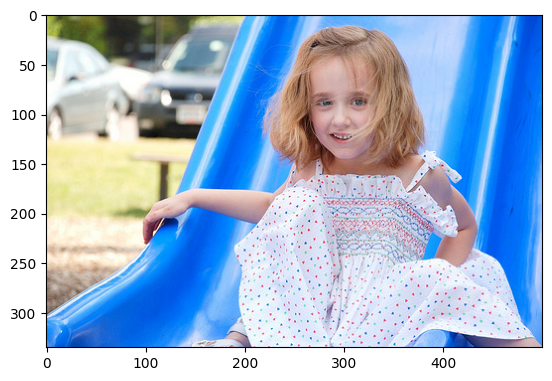

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse
from keras.models import load_model
from keras.applications.xception import Xception
from keras.preprocessing.sequence import pad_sequences
from pickle import load

'''
# Argument parser
ap = argparse.ArgumentParser()
ap.add_argument('-i', '--image', required=True, help="Image Path")
args = vars(ap.parse_args())
img_path = args['image']
'''

img_path = '/content/640409060_6af18fdd54.jpg'

# Extract features from image using Xception model
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Can't open image! Ensure that image path and extension is correct")
        return None

    image = image.resize((299, 299))
    image = np.array(image)

    # For 4 channels images, convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]

    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0

    feature = model.predict(image)
    return feature

# Map integer to word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

'''
# Generate description for an image
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
'''

def generate_desc(model, tokenizer, photo, max_length):
    start_token = 'startseq'
    end_token = 'endseq'

    in_text = [tokenizer.texts_to_sequences([start_token])[0]]
    for _ in range(max_length):
        sequence = pad_sequences(in_text, maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)

        if pred == tokenizer.word_index[end_token]:
            break

        word = tokenizer.index_word.get(pred, '')
        if word:
            in_text[0].append(pred)

    # Convert indices to words and remove startseq and endseq tokens
    caption = [tokenizer.index_word.get(idx) for idx in in_text[0] if idx > 0]
    caption = ' '.join(caption).replace(start_token, '').replace(end_token, '').strip()

    return caption

# Load the necessary models and tokenizer
max_length = 35
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('/content/drive/MyDrive/Model/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

# Extract features from the provided image
photo = extract_features(img_path, xception_model)
if photo is None:
    exit()

# Open the image
img = Image.open(img_path)

# Generate description for the image
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)

# Display the image
plt.imshow(img)
plt.show()


In [ ]:
gpt / why do we define extract_features function again, although we define the function name extract_features above in the code (before training).
And what is the role of argument parser part? I want to train this model and test it in google colab, is this code works well in google colab?